In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool

Phonological similarity function (same as namesake but Levenshtein package instead of fuzzywuzzy)

In [2]:
from Levenshtein import ratio
import eng_to_ipa

def get_phono_sim(name1, name2):

    name1_ipa = eng_to_ipa.convert(name1)
    name2_ipa = eng_to_ipa.convert(name2)

    return ratio(name1_ipa, name2_ipa)

In [3]:
df = pd.read_csv('homophones.csv')

rows, cols = df.shape

ndarray = np.array(df, dtype=str)

for r in range(rows):
    print(ndarray[r][0] + '\t' + ndarray[r][1] + '\tndarray: '
          + str(np.round(get_phono_sim(ndarray[r][0], ndarray[r][1]), 2)) + '\tdf: '
          + str(np.round(get_phono_sim(df.iloc[r][0], df.iloc[r][1]), 2)))

cast	cats	ndarray: 0.7	df: 0.75
red	read	ndarray: 0.88	df: 1.0
text	test	ndarray: 0.95	df: 0.89
label	table	ndarray: 0.67	df: 0.86
k	case	ndarray: 0.0	df: 0.86
fields	files	ndarray: 0.9	df: 0.6
date	weight	ndarray: 0.44	df: 0.75
best	test	ndarray: 0.9	df: 0.75
len_col	n_cols	ndarray: 0.75	df: 0.8
norm	form	ndarray: 0.91	df: 0.75
score	store	ndarray: 0.92	df: 0.75
levels	labels	ndarray: 0.87	df: 0.67
state	stats	ndarray: 0.88	df: 0.6
axes	axis	ndarray: 0.86	df: 0.62


Single threaded baseline (10,000 iter in ~100 seconds => 100 iter/s)

In [4]:
id_freq = pd.read_csv('identifier_frequency.csv')

top_100 = id_freq['identifier'][:100]

similar_pairs = []

for i in tqdm(range(100)):
    for j in range(100):

        s = get_phono_sim(top_100[i], top_100[j])
        
        if i != j and s > 0.5:
            similar_pairs.append((top_100[i], top_100[j], s))

pd.DataFrame(similar_pairs).to_csv('most_similar_identifiers.csv')

100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


In [5]:
def partition_triangle_matrix(size, n_partitions):
    
    partitions = [0]
    partition_area = (size**2)/(2*n_partitions)

    area = 0
    for col in range(size):
        area += col
        if area >= partition_area:
            area = 0
            partitions.append(col)
    
    partitions.append(size)

    assert len(partitions) == n_partitions + 1

    indices = []
    for i in range(n_partitions):
        indices.append((partitions[i], partitions[i+1]))

    return indices

In [6]:
def similarity_matrix(words, l_bound, r_bound):
    size = len(words)
    result = np.zeros((size, size))

    for i in range(l_bound, r_bound):
        for j in range(size):
            if j < i:
                try:
                    result[i, j] = get_phono_sim(words[i], words[j])
                except TypeError:
                    print(i, words[i], j, words[j])
    return result

In [7]:
def multiprocess_similarity_matrix(words, processes=8):

    size = len(words)
    
    indices = partition_triangle_matrix(size, processes)

    with Pool(processes=processes) as pool:

        parts = []

        for i in range(processes):

            parts.append(pool.apply_async(similarity_matrix, (words, indices[i][0], indices[i][1])))

        for p in parts:
            p.wait()
    
    result_list = []
    
    for p in parts:
        result_list.append(p.get())

    results = np.sum(np.array(result_list), axis=0)
    results = results

    return results

In [9]:
id_freq = pd.read_csv('identifier_frequency.csv', dtype=str)

top_1000 = id_freq['identifier'][:1000].astype(str)

result = multiprocess_similarity_matrix(top_1000, 16)

In [10]:
print(top_1000.dtype)

object


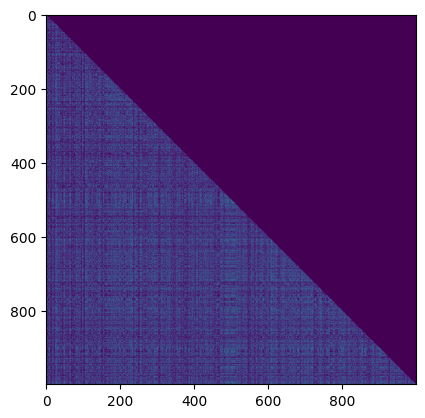

In [11]:
import matplotlib.pyplot as plt

plt.imshow(result)

In [15]:
sort = np.flip(np.argsort(result, axis=None))

for i in range(1000):
    x, y = np.unravel_index(sort[i], (1000, 1000))

    word1, word2 = top_1000[x], top_1000[y]
    if word1 not in word2 and word2 not in word1:
        print(word1 + ',' + word2 + ',' + str(np.round(result[x,y], 3)))

nu,new,1.0
eye,i,1.0
category,categories,0.952
maxiter,max_iter,0.941
csc_matrix,csr_matrix,0.909
text,test,0.889
bits,bytes,0.889
encoded,encoding,0.889
arrays,res,0.889
init,int,0.889
cols,cls,0.889
result1,result2,0.875
x_trans,x_train,0.875
y_train,x_train,0.875
setattr,getattr,0.875
assert_almost_equal,assert_array_almost_equal,0.87
ndtype,dtypes,0.857
label,table,0.857
ix,idx,0.857
tp,tup,0.857
n_iter,nditer,0.857
a1,ax1,0.857
cs,cls,0.857
ctypes,dtypes,0.857
y_test,pytest,0.857
qs1,q1,0.857
d1,df1,0.857
phi,file,0.857
ex,checks,0.857
cf,clf,0.857
nt,npt,0.857
section,second,0.857
tp,typ,0.857
cl,col,0.857
sign,sin,0.857
svc,sc,0.857
rhs,rs,0.857
y_test,x_test,0.857
a2,ax2,0.857
ops,opts,0.857
rvs,rs,0.857
case,k,0.857
d2,df2,0.857
tp,tmp,0.857
checks,x,0.857
cast,cat,0.857
high,height,0.857
dt1,d1,0.857
ft,fmt,0.857
cv,cov,0.857
assert_array_almost_equal,assert_array_equal,0.844
expression,exception,0.842
status,stats,0.833
reader,order,0.833
wrapper,repr,0.833
ydata,xdata,0.833